# 04 - Shots Sweep and NoiseProfile (PennyLane & Qiskit)

This notebook compares uncertainty vs. shots for both PennyLane and Qiskit
on the same toy dataset, using `NoiseProfile`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import pennylane.numpy as pnp
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.primitives import Sampler

from quantumuq import NoiseProfile, wrap_qiskit_sampler, wrap_qnode
from quantumuq.datasets.toy import make_moons

rng = np.random.default_rng(0)
dataset = make_moons(n_samples=200, noise=0.1, random_state=0)
X, y = dataset.X, dataset.y
X_sub = X[:40]
y_sub = y[:40]

In [2]:
# PennyLane predictor
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits, shots=1000)
params = 0.1 * pnp.array(
    rng.standard_normal(qml.StronglyEntanglingLayers.shape(1, n_qubits))
)

@qml.qnode(dev)
def pl_circuit(features, params):
    qml.AngleEmbedding(features, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

# Reuse the same 4->2 mapping idea as in other notebooks
# class 0: P(0*), class 1: P(1*)
def probs_4_to_2(probs):
    p = pnp.array(probs)
    if p.ndim == 1:
        return pnp.array([p[0] + p[1], p[2] + p[3]])
    return pnp.stack([p[:, 0] + p[:, 1], p[:, 2] + p[:, 3]], axis=-1)

pl_predictor = wrap_qnode(
    pl_circuit,
    task="classification",
    n_classes=2,
    params=params,
    postprocess=probs_4_to_2,
)

pl_profile = NoiseProfile(sweep_shots=[100, 500, 1000], n_repeats=3)
pl_results = pl_profile(pl_predictor, X_sub)

In [3]:
# Qiskit predictor
theta = Parameter("theta")
qc = QuantumCircuit(1)
qc.ry(theta, 0)
qc.measure_all()

def q_feature_map(X_batch):
    X_arr = np.asarray(X_batch)
    if X_arr.ndim == 1:
        X_arr = X_arr[0:1]
    return [[float(x[0])] for x in X_arr]

sampler = Sampler()
q_predictor = wrap_qiskit_sampler(
    sampler=sampler,
    circuit=qc,
    task="classification",
    n_classes=2,
    feature_map=q_feature_map,
)

q_profile = NoiseProfile(sweep_shots=[100, 500, 1000], n_repeats=3)
q_results = q_profile(q_predictor, X_sub)

/var/folders/rh/1c0lrj_x0x956417g86lc4ph0000gn/T/ipykernel_16900/3753545572.py:13: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


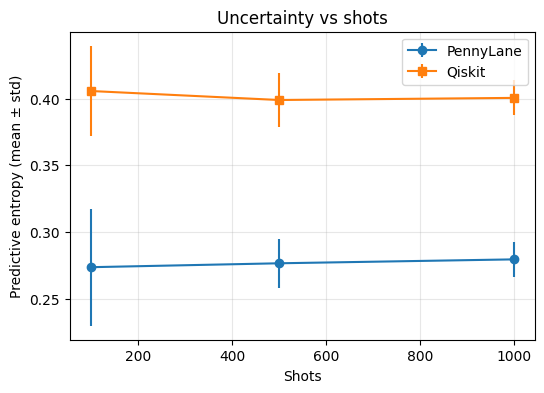

In [4]:
def summarize_entropy(results):
    shots = sorted(results.keys())
    mean_ent = [results[s]["mean_entropy"].mean() for s in shots]
    std_ent = [results[s]["std_entropy"].mean() for s in shots]
    return shots, mean_ent, std_ent

pl_shots, pl_mean, pl_std = summarize_entropy(pl_results)
q_shots, q_mean, q_std = summarize_entropy(q_results)

plt.figure(figsize=(6, 4))
plt.errorbar(pl_shots, pl_mean, yerr=pl_std, fmt="o-", label="PennyLane")
plt.errorbar(q_shots, q_mean, yerr=q_std, fmt="s-", label="Qiskit")
plt.xlabel("Shots")
plt.ylabel("Predictive entropy (mean ± std)")
plt.title("Uncertainty vs shots")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()